In [2]:
import sys
sys.path.append('../../')

In [3]:
from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter

from numpy.polynomial.polynomial import polyfit, polyval

In [4]:
def DFA_main(DATA):
    # output:
    # F_n: RMS(Root Mean Squared) values in each window length
    # Alpha1: the Hurst exponent
    N = len(DATA)  # length of the data
    win_lengths = np.arange(5, len(DATA)/2, 5).astype(int) # how many different win_lengths, customized to your data
    Nw = len(win_lengths) # number of different win_length
    F_n = np.zeros(Nw) # initialize RMS values in the FDA time series
    order=1 # (default to 1 in DFA_main function);

    for iw in range(Nw):
        win_length=win_lengths[iw]
        n = int(np.floor(N / win_length))  # the number of windows
        N1 = n * win_length  # new length of the truncated data 
        # initialize y
        y = np.zeros(N1)  # sum of deviations from the grand mean in all data length
        # initialize fitcoef
        mean1 = np.mean(DATA[:N1]) # grand mean of the truncated data
        # sum of deviations from the grand mean in all data length
        for i in range(N1):
            y[i] = np.sum(DATA[:i+1] - mean1)

        # polynomial coefficients in each window
        fitcoef = np.zeros((n, order + 1))
        for j in range(n):
            fitcoef[j,:] = np.polyfit(np.arange(1, win_length+1), y[j*win_length:(j+1)*win_length], order)
        
        # initialize Yn (the new Y values in each window)
        Yn = np.zeros(N1)
        for j in range(n): # the number of windows
            Yn[j*win_length:(j+1)*win_length] = np.polyval(fitcoef[j,:], np.arange(1, win_length+1))

        sum1 = np.sum((y.T - Yn)**2) / N1 # take the mean square
        sum1 = np.sqrt(sum1) # take the root
    
        F_n[iw] = sum1 # the final RMS (root mean squared value)

    A = np.polyfit(np.log10(win_lengths), np.log10(F_n), 1)
    Alpha1 = A[0]
    FitValues = np.polyval(A, np.log10(win_lengths))
    return win_lengths, F_n, Alpha1, FitValues
    

In [5]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes   


In [6]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

In [7]:
def segmenteegdata(eegdata,epochlength,samplingrate):
    epoch = int(epochlength*samplingrate)
    nsamp = np.shape(eegdata)[0]
    nchan = np.shape(eegdata)[1]
    nepoch = int(nsamp/epoch)
    nsamp = nepoch*epoch
    segdata = np.reshape(eegdata[0:nsamp,0:nchan],(nepoch,epoch,nchan))
    return segdata


In [8]:
epoch = 1 #units: seconds
matfile = list()
filedir="../../"
pathname = 'Cleaned_data/'
for file in listdir(filedir+pathname):
	if file.endswith(".mat"):
		matfile.append(file)

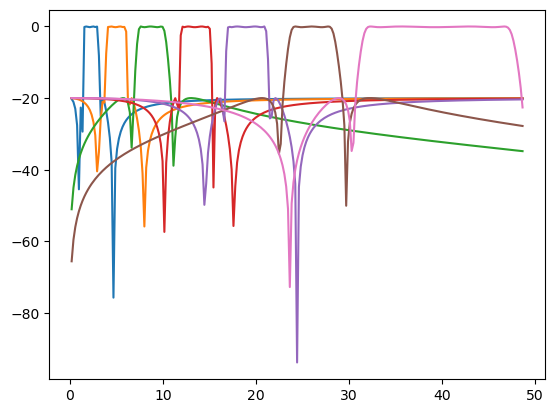

In [9]:
srnew = 200 
downsample = 10 
passbands = [[1.5,3],[4,6],[7.5,10],[12,15],[17 ,21],[24,28],[32,47]]
stopbands = [[1,3.5],[3.5,6.5],[6.5,11],[11,16],[16,22],[22,30],[30,50]]
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)
    plt.plot(w[1:250],20*np.log10(np.abs(h[1:250])))

In [16]:
ses=0
trl=1

filename = matfile[ses]
[eeg, intervals, samples, condition_index, session, sr, bpchan, 
   		condition_Names, channels, chan_labels, sessionTypes] \
			= loaddata(filedir+pathname+filename)
#lowpass filter for downsampling
sos_low, w,h = makefiltersos(sr,50,55)
for trl in range(12): # for each trial
	#align the length of the two files. 
	nsamp1 = np.shape(eeg[0][trl])[0]
	nsamp2 = np.shape(eeg[1][trl])[0]
	nsamp = np.min((nsamp1,nsamp2))
	for subj in range(2): # for each subject
		trialdata = avref(eeg[subj][trl][0:nsamp,0:32]) 
		trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
		trialdatanew = trialdata[range(0,nsamp,downsample),:]
		filtdata = dict()
		time = dict()
		hilbertdata = dict()
		empirical_ampcorr = dict()
		phasecorr = dict() #need to to do this still. 
		for freq in range(len(passbands)):
			filtdata[freq] = sosfiltfilt(esos[freq],trialdatanew,axis = 0,padtype ='odd')
			hilbertdata[freq] = hilbert(filtdata[freq],axis = 0)
			empirical_ampcorr[freq] = np.corrcoef(np.transpose(np.abs(hilbertdata[freq])))


# takes 46s for one trial
		

Things to be added now: 
(1) incorporate the analysis of the inverse covariance on the hilbertdata.  Dont forget to remove the mean.  Should be more reasonable to manage now, since there are just 6 bands. 
(2) incorporate the dfa analysis on the envelope time series. (abs of hilbertdata) 
After this are some plots that are useful to visualize things. 
(3) Its going to be more difficult to save all these hilbert outputs of different sizes into one big array.  Do we need to really save it? 
(4) I need to make a phase version of this.  But I am confused. 

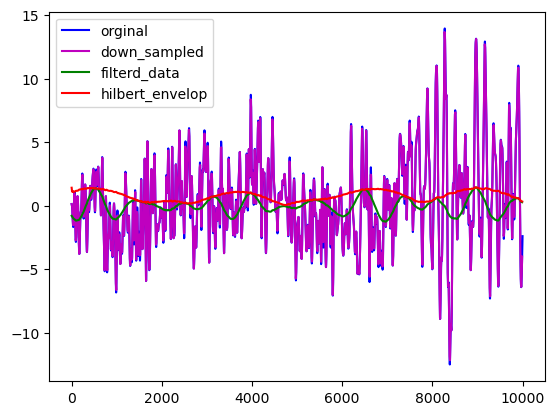

In [14]:
plt.plot(range(10000),trialdata[0:10000,6],'b',label='orginal')

plt.plot(range(0,10000,10),trialdatanew[0:1000,6],'m',label='down_sampled')

plt.plot(range(0,10000,10),filtdata[0][0:1000,6],'g',label='filterd_data')

plt.plot(range(0,10000,10),np.abs(hilbertdata[0][0:1000,6]),'r',label='hilbert_envelop')

plt.legend()

C:\Users\zhouz\AppData\Local\Temp\ipykernel_19568\4020029177.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = np.sum(DATA[:i+1] - mean1)


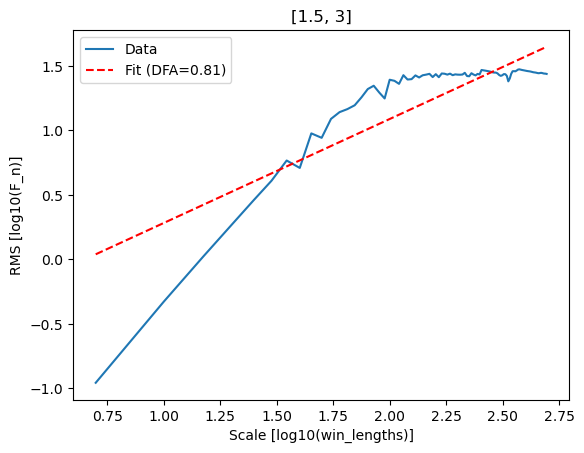

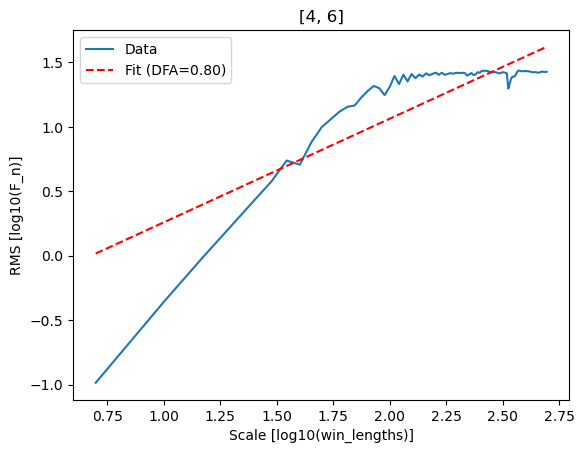

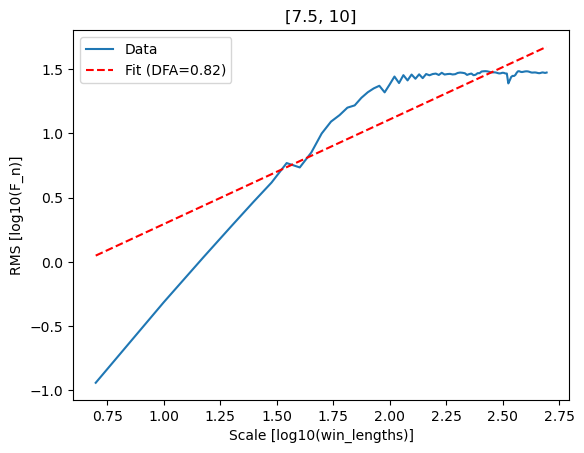

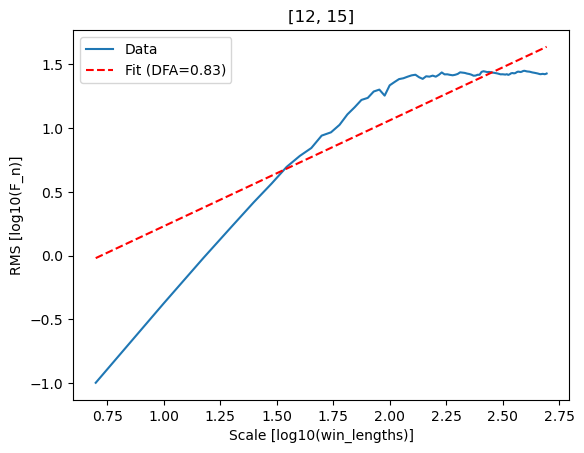

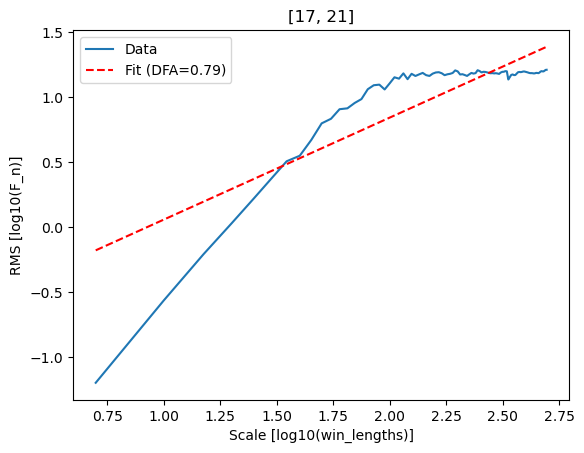

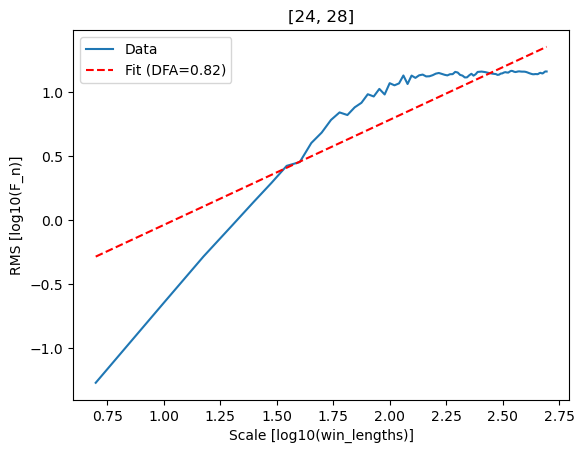

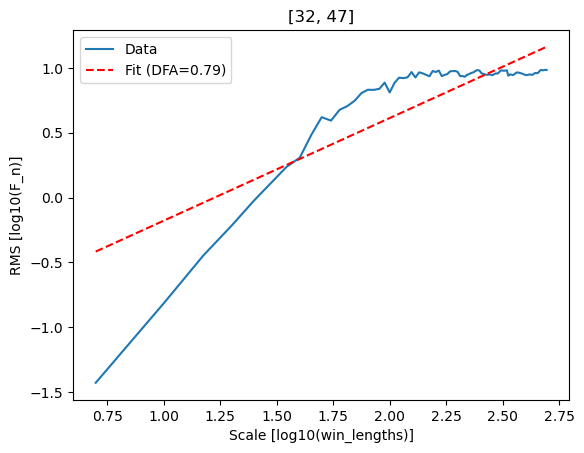

In [15]:
# try DFA
for j in range(len(passbands)):
    win_lengths, F_n, Alpha1, FitValues=DFA_main(hilbertdata[0][0:1000,j])
    plt.plot(np.log10(win_lengths), np.log10(F_n))
    plt.xlabel('Scale [log10(win_lengths)]')
    plt.ylabel('RMS [log10(F_n)]')
    plt.plot(np.log10(win_lengths), FitValues, 'r--')
    plt.legend(['Data', f"Fit (DFA={Alpha1:.2f})"])
    plt.title(str(passbands[j]))
    plt.show()

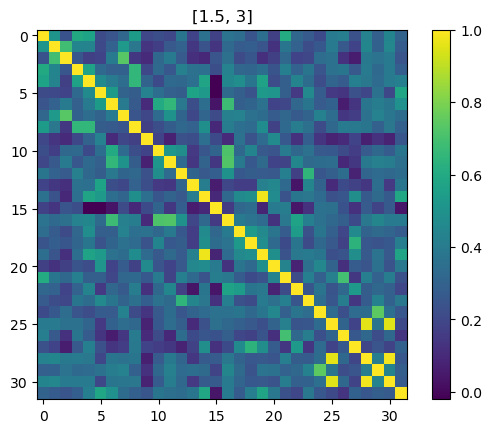

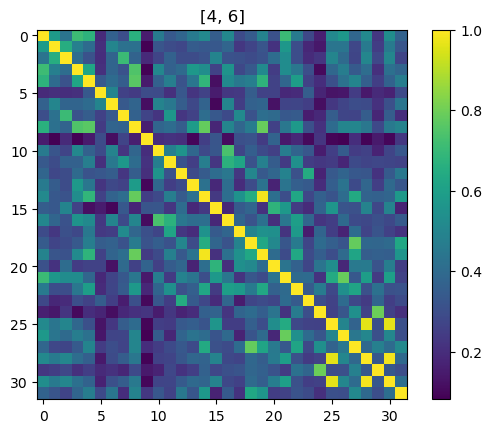

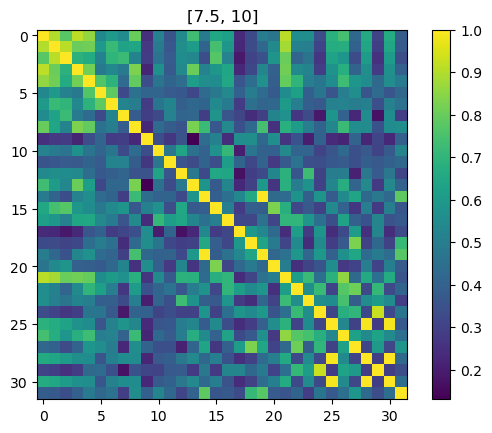

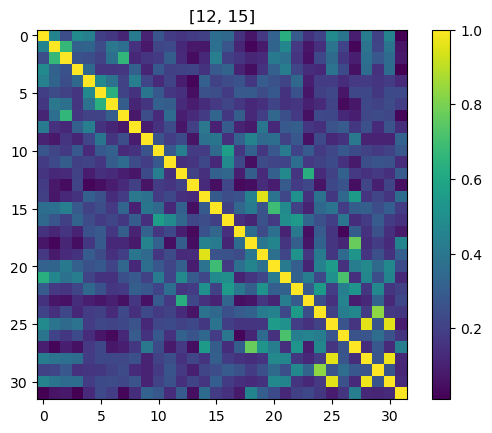

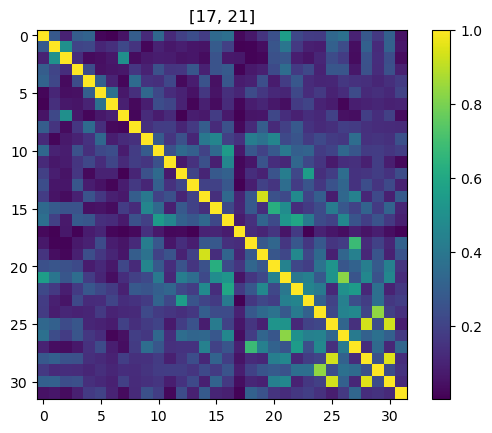

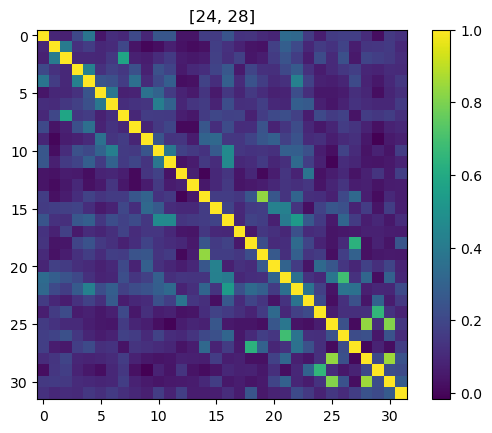

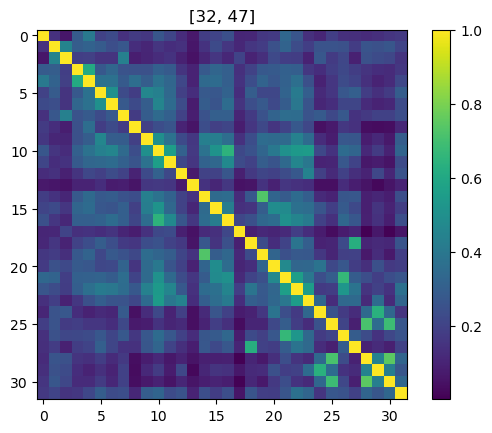

In [21]:
for j in range(len(passbands)):
    plt.figure()
    plt.imshow(empirical_ampcorr[j])
    plt.colorbar()
    plt.title(str(passbands[j]))